# Task 1: Import Libraries

In [ ]:
# prompt: connect only to a folder in google drive and mount it in the current directory

from google.colab import drive
import os

# Mount the specific folder in Google Drive
folder_name = "MyDrive/vision-transformer-classification"
mount_point = "/content/drive"

drive.mount(mount_point)

# Change the current working directory to the mounted folder
os.chdir(os.path.join(mount_point, folder_name))

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/MyDrive/vision-transformer-classification


In [ ]:
#!pip install transformers datasets

In [ ]:
#!pip install accelerate -U

In [ ]:
import os

def create_folder(folder_name):
  if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Created folder: {folder_name}")
  else:
    print(f"Folder already exists: {folder_name}")

# Example usage
create_folder("gtsrb_data")
create_folder("logs")
create_folder("trained_model")


Folder already exists: gtsrb_data
Folder already exists: logs
Folder already exists: trained_model


In [ ]:
from PIL import Image
from datasets import load_dataset, ClassLabel
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from torchvision import transforms
import sklearn
import numpy as np
import torch
from datetime import datetime
import os
import io

# Task 2: Load the Dataset

In [ ]:
from datasets import load_dataset, concatenate_datasets
# load stanford dogs dataset
path = 'gtsrb_data'
ds = load_dataset('bazyl/GTSRB', cache_dir=path)

# read labels.txt that has "class_id: class_name," mapping in each line
id2label = {}
with open(os.path.join(path, 'labels.txt'), 'r') as f:
    for line in f:
        class_id, class_name = line.split(': ')
        # remove ' and , from class_name
        class_name = class_name.replace("\n","").replace("'", "").replace(",", "")
        id2label[int(class_id)] = class_name
print(id2label)

temp_ds = ds['train']

num_train_samples_per_class = 100
label_samples = {}

# Get unique labels
labels = temp_ds.unique('ClassId')

# Select samples for each label
for label in labels:
    samples = temp_ds.filter(lambda x: x['ClassId'] == label).shuffle(seed=42).select(range(int(num_train_samples_per_class*1.1)))
    label_samples[label] = samples

# Initialize an empty dataset with the same structure as train_ds
train_val_ds = temp_ds.select([])

# Concatenate each label's samples into the new_train_ds
for label in labels:
    train_val_ds = concatenate_datasets([train_val_ds, label_samples[label]])

splits = train_val_ds.train_test_split(test_size=0.1,shuffle=True)
train_ds = splits["train"]
validation_ds = splits["test"]

# Print or use the new train dataset
print(train_ds)
test_ds = ds['test']

# map the image path to the image bytes
train_ds = train_ds.map(lambda x: {'image': Image.open(io.BytesIO(x['Path']['bytes'])).convert('RGB'), 'label': x['ClassId']})
test_ds = test_ds.map(lambda x: {'image': Image.open(io.BytesIO(x['Path']['bytes'])).convert('RGB'), 'label': x['ClassId']})
validation_ds = validation_ds.map(lambda x: {'image': Image.open(io.BytesIO(x['Path']['bytes'])).convert('RGB'), 'label': x['ClassId']})


# print the number of samples in each dataset and the number of classes
print(f"Number of samples in train dataset: {len(train_ds)}")
print(f"Number of samples in validation dataset: {len(validation_ds)}")
print(f"Number of samples in test dataset: {len(test_ds)}")
print(f"Number of classes: {len(train_ds.unique('label'))}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing for vehicles over 3.5 metric tons', 11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Vehicles over 3.5 metric tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left', 20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End of all speed and passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight o

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39209 [00:00<?, ? examples/s]

Dataset({
    features: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path'],
    num_rows: 4257
})


Map:   0%|          | 0/4257 [00:00<?, ? examples/s]

Map:   0%|          | 0/473 [00:00<?, ? examples/s]

Number of samples in train dataset: 4257
Number of samples in validation dataset: 473
Number of samples in test dataset: 12630
Number of classes: 43


# Task 3: Visualize the Dataset

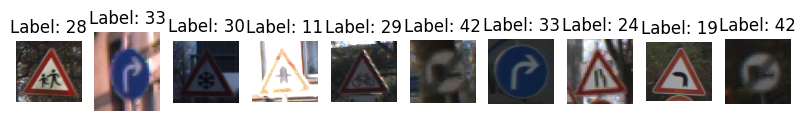

In [ ]:
# visualize gtsrb few samples from train_ds
def show_samples(dataset, num_samples=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        image = dataset[i]['image']
        label = dataset[i]['label']
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.show()
show_samples(train_ds)

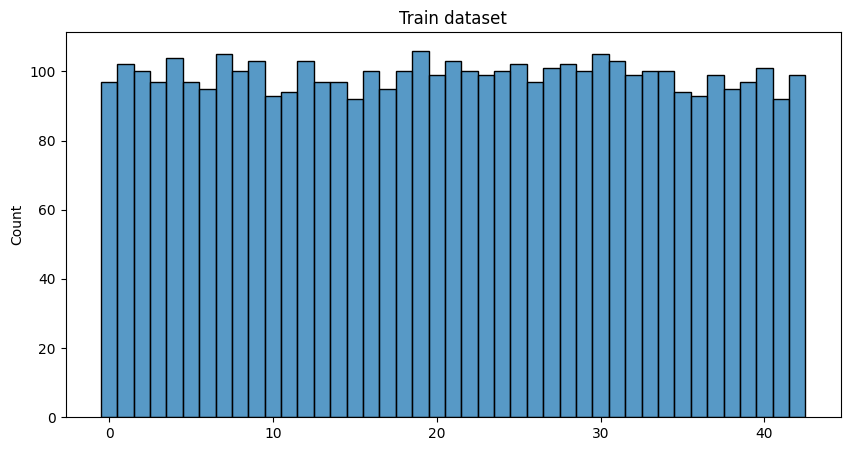

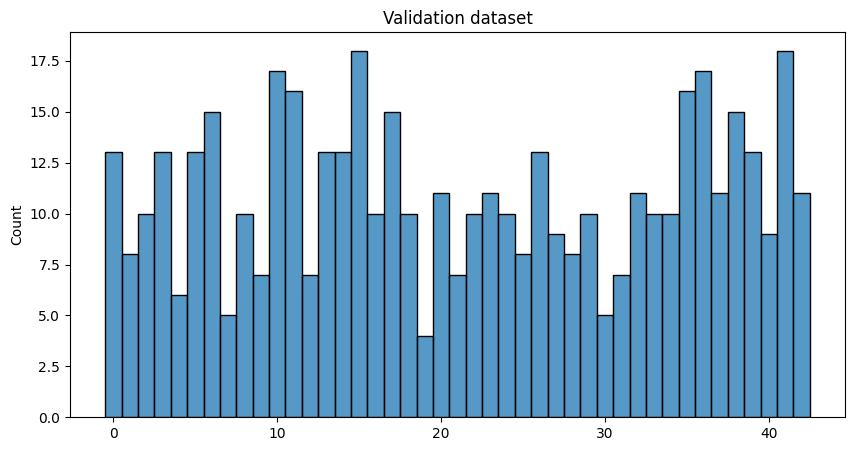

In [ ]:
train_labels = Counter(train_ds['label'])

# plot the frequency of each label in the training and validation datasets as histograms
def plot_frequency(dataset, title):
    plt.figure(figsize=(10, 5))
    sns.histplot(dataset, discrete=True)
    plt.title(title)
    plt.show()
plot_frequency(train_ds['label'], 'Train dataset')
plot_frequency(validation_ds['label'], 'Validation dataset')

# Task 4: Create a Mapping of Class Names to Index

In [ ]:
label2id = {t[1] : t[0] for t in id2label.items()}
num_labels = len(id2label)

print(id2label)

{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing for vehicles over 3.5 metric tons', 11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Vehicles over 3.5 metric tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left', 20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End of all speed and passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight o

# Task 5: Load the Preprocessor for the Dataset

In [ ]:
PRETRAINED_MODEL_NAME = 'google/vit-base-patch16-224'
processor = ViTImageProcessor.from_pretrained(PRETRAINED_MODEL_NAME)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

# Task 6: Define Data Augmentations

In [ ]:
image_mean, image_std = processor.image_mean, processor.image_std
height, width = processor.size['height'], processor.size['width']

normalize = transforms.Normalize(mean=image_mean,std=image_std)

_train_transforms = transforms.Compose([
                                    transforms.RandomAffine(degrees=10,translate=(0.1,0.1),scale=(0.9,1.1)),
                                    transforms.Resize((height,width)),
                                    transforms.ToTensor(),
                                    normalize])

_validation_transforms = transforms.Compose([
                                    transforms.Resize((height,width)),
                                    transforms.ToTensor(),
                                    normalize])

# Task 7:  Implement Data Transformation

In [ ]:
def train_transforms(batch):
    rgb_images = [img.convert('RGB') for img in batch['image']]
    batch['pixel_values'] = [_train_transforms(img) for img in rgb_images]
    return batch

def validation_transforms(batch):
    rgb_images = [img.convert('RGB') for img in batch['image']]
    batch['pixel_values'] = [_validation_transforms(img) for img in rgb_images]
    return batch

train_ds.set_transform(train_transforms)
validation_ds.set_transform(validation_transforms)
test_ds.set_transform(validation_transforms)

# Task 8: Collate the Function for DataLoader

In [ ]:
def collate_fn(batch):
    pixel_values = torch.stack([sample['pixel_values'] for sample in batch])
    labels = torch.tensor([sample['label'] for sample in batch])
    return {'pixel_values' : pixel_values, 'labels' : labels}

# Task 9: Create a Model

In [ ]:
model = ViTForImageClassification.from_pretrained(pretrained_model_name_or_path=PRETRAINED_MODEL_NAME,
                                                num_labels = num_labels,
                                                id2label = id2label,
                                                label2id = label2id,
                                                ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([43]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([43, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Task 10: Define a Metric for the Model

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = sklearn.metrics.f1_score(labels, predictions, average='macro') # just average the metrics
    return {'f1' : f1}

# Task 11: Set Up Trainer Arguments

In [ ]:
# !pip show transformers
# !pip show accelerate
# !pip show torch
output_dir ='./trained_model'
# create unique directory name for tensorboard logs
tensorboard_dir = f'./logs/{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'
training_args = TrainingArguments(output_dir=output_dir,
                                                 num_train_epochs=20,
                                                 learning_rate=0.00001,
                                                 per_device_train_batch_size=32,
                                                 per_device_eval_batch_size=64,
                                                 logging_dir=tensorboard_dir,
                                                 logging_strategy='epoch',
                                                 evaluation_strategy='epoch',
                                                 remove_unused_columns=False,
                                                 load_best_model_at_end=True,
                                                 save_strategy='epoch',
                                                 metric_for_best_model="eval_loss",
                                                greater_is_better=False,
                                                warmup_ratio=0.1
                                                 )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Task 12: Create a Trainer Object

In [ ]:
class MNISTTrainer(Trainer):
    # write a custom collate function
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_collator = collate_fn

trainer = MNISTTrainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_ds,
                  eval_dataset=validation_ds,
                  )

# Task 13: Evaluate the Model Before Training

In [ ]:
trainer.evaluate()

{'eval_loss': 3.9163379669189453,
 'eval_f1': 0.014594868955334071,
 'eval_runtime': 2.2252,
 'eval_samples_per_second': 212.564,
 'eval_steps_per_second': 3.595}

# Task 14: Train the Model

In [ ]:
# # freeze all the layers except the last layer
# for name, param in model.named_parameters():
#     if 'classifier' not in name:
#         param.requires_grad = False
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,Training Loss,Validation Loss,F1
1,3.828700,3.683654,0.052320
2,3.172800,2.656550,0.377735
3,1.766200,1.260526,0.841383
4,0.750100,0.552674,0.935778
5,0.346900,0.285758,0.965178
6,0.164600,0.156433,0.988730
7,0.092700,0.101027,0.991080
8,0.062500,0.072597,0.994707
9,0.038500,0.055997,0.992672
10,0.030600,0.044742,0.996614


TrainOutput(global_step=2680, training_loss=0.5189591213838378, metrics={'train_runtime': 3203.4276, 'train_samples_per_second': 26.578, 'train_steps_per_second': 0.837, 'total_flos': 6.600092441053225e+18, 'train_loss': 0.5189591213838378, 'epoch': 20.0})

# Task 15: Visualize the Performance in TensorBoard

In [ ]:
# visualize the training loss, learning rate and f1 score using tensorboard in vscode
#%load_ext tensorboard
#!tensorboard --logdir './logs'

# Task 16: Evaluate the Model

In [ ]:
# clear the cache in ./trained_model
!rm -r ./trained_model/*
trainer.evaluate(test_ds)

{'eval_loss': 0.08635649085044861,
 'eval_f1': 0.9652029679079105,
 'eval_runtime': 165.5197,
 'eval_samples_per_second': 76.305,
 'eval_steps_per_second': 1.196,
 'epoch': 20.0}

# Task 17: Set Up the Confusion Matrix

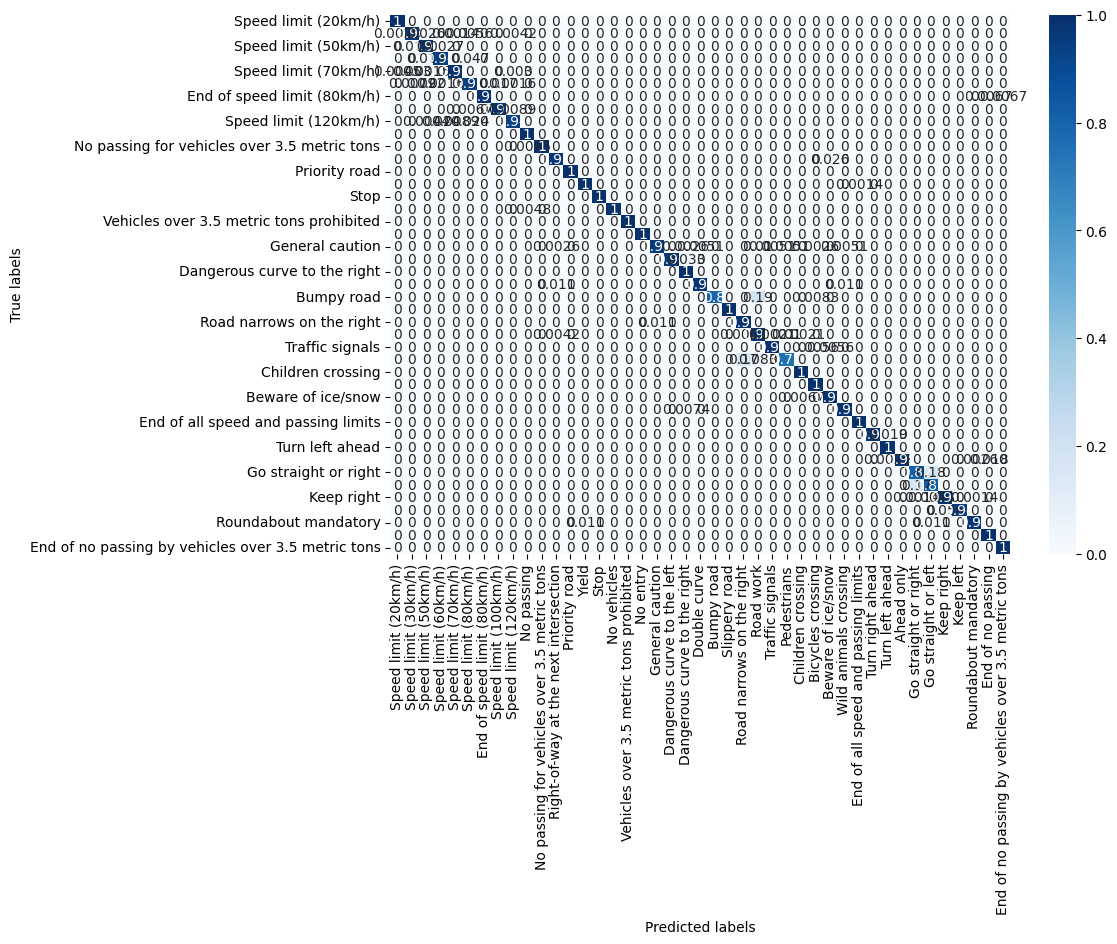

In [ ]:
# setup the confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(10,7))
    sns.heatmap(df_cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

# get the predictions
predictions = trainer.predict(test_ds)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)
plot_confusion_matrix(y_true, y_pred, id2label.values())

# Task 18: Save the Model and Metrics

In [ ]:
# save the best model and metrics
trainer.save_model(output_dir)
trainer.save_metrics(output_dir, metrics=trainer.state.log_history[-1])
trainer.state.save_to_json(f'{output_dir}/trainer_state.json')

# Task 19: Push the model to huggingface

In [ ]:
# !huggingface-cli login
# !huggingface-cli repo create mnist_vit -y